In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2

In [2]:
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Input, Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, SeparableConv2D 

In [3]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
VAL_SPLIT = 0.2
SEED = 157
LABELS = 'binary'
DATA_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [4]:
dict_labels = {'PNEUMONIA': 0, 'NORMAL': 1}

In [5]:
def dataset(path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(path, folder, file)
            # print(path_of_file)
            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)
    images, labels = shuffle(images, labels)
    return images, labels



In [6]:
x_train, y_train = dataset(os.path.join(DATA_PATH, 'train'))
x_test, y_test = dataset(os.path.join(DATA_PATH, 'test'))
x_val, y_val = dataset(os.path.join(DATA_PATH, 'val'))

100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


<Axes: xlabel='0', ylabel='count'>

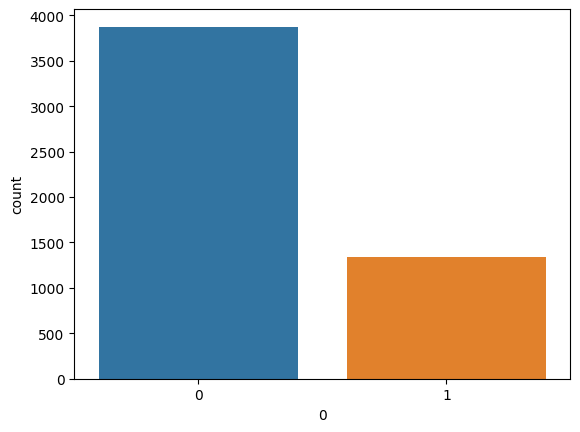

In [7]:
y_train_pandas = pd.DataFrame(y_train)
sns.countplot(y_train_pandas, x = 0)

# 0 => for the Pneumonia, 1 => Normal

In [8]:
x_train = x_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
x_test = x_test.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
x_val = x_val.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

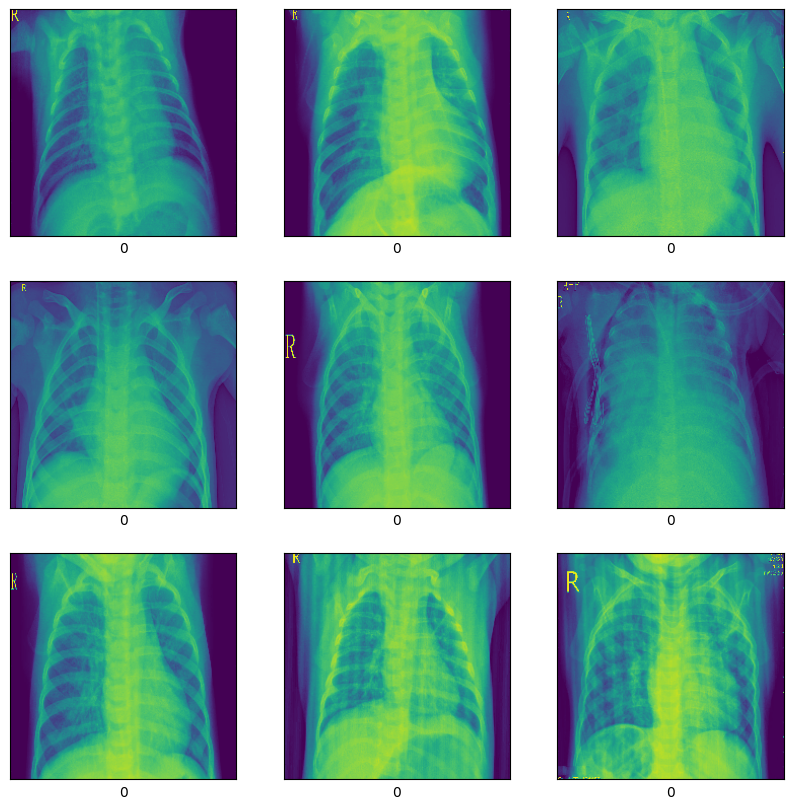

In [9]:
plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = x_train[i]
    plt.xlabel(str(str(y_train[i])))
    plt.imshow(data);

In [124]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

**For the data augmentation, i choosed to :**

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

In [125]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [126]:
def build_model():
    model = Sequential([
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        
        Conv2D(16, 3, activation='relu', padding='same'),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        Dropout(0.2),
        
        conv_block(256),
        Dropout(0.2),

        conv_block(516),
        Dropout(0.2),
        
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [127]:
COUNT_PNEUMONIA = y_train[y_train==0].shape[0]
COUNT_NORMAL = y_train[y_train==1].shape[0]
TRAIN_IMG_COUNT = y_train.shape[0]

In [128]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.06113006])

In [129]:
weight_for_1 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_0 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 1.94


In [104]:
# Separate the classes (assuming x_train and y_train are numpy arrays)
x_1 = x_train[y_train == 1]
x_0 = x_train[y_train == 0]

# Randomly sample from the majority class (class 0)
indices_0 = np.random.choice(x_0.shape[0], size=len(x_1) + 500, replace=False)  # Random indices from x_0

# Create the undersampled x_0
x_0_undersampled = x_0[indices_0]

# Combine the undersampled majority class (x_0) with the minority class (x_1)
x_train_undersampled = np.concatenate([x_1, x_0_undersampled], axis=0)

# Similarly, for y_train (labels)
y_train_undersampled = np.concatenate([y_train[y_train == 1], y_train[y_train == 0][indices_0]], axis=0)

x_train_undersampled, y_train_undersampled = shuffle(x_train_undersampled, y_train_undersampled)

In [118]:
# model=tf.keras.applications.ResNet50(
#     include_top=True,
#     weights=None,
#     input_shape=(IMG_HEIGHT,IMG_WIDTH,1),
#     classes=1,
#     classifier_activation='sigmoid'
# )

In [136]:
model = build_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
    ]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
    )

In [137]:
history = model.fit(
   x_train, y_train, epochs = 12, validation_data = (x_val, y_val),
    class_weight=class_weight,
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.5897 - loss: 0.7830 - precision: 0.3303 - recall: 0.5970 - val_accuracy: 0.5000 - val_loss: 0.8763 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8784 - loss: 0.2842 - precision: 0.6916 - recall: 0.9466 - val_accuracy: 0.5000 - val_loss: 1.4753 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9198 - loss: 0.1966 - precision: 0.7869 - recall: 0.9461 - val_accuracy: 0.5000 - val_loss: 2.1765 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9313 - loss: 0.1799 - precision: 0.8158 - recall: 0.9474 - val_accuracy: 0.5000 - val_loss: 2.5694 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9522 - loss: 0.1313 - precision: 0.8692 - recall: 0.

In [138]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8654 - loss: 0.3689 - precision: 0.9443 - recall: 0.6851
Loss of the model is -  0.40093064308166504
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8654 - loss: 0.3689 - precision: 0.9443 - recall: 0.6851
Accuracy of the model is -  87.0192289352417 %


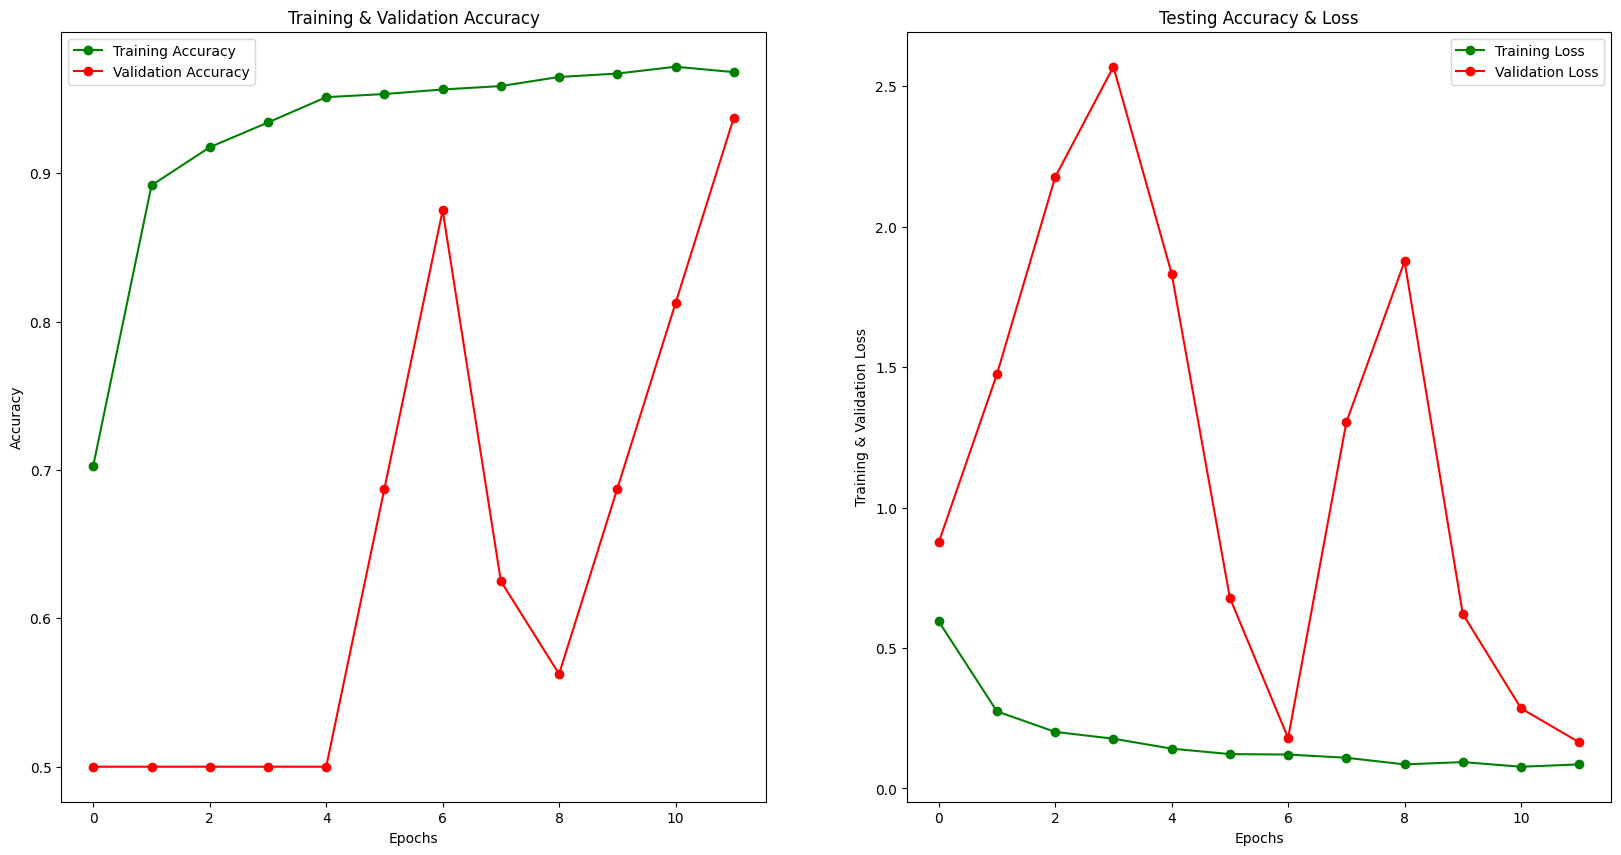

In [139]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [146]:
predictions = model.predict(x_test) > 0.5
predictions = predictions.astype(int)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1])

In [143]:
y_test[:15]

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1])

In [147]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.98      0.90       390
   Normal (Class 1)       0.95      0.69      0.80       234

           accuracy                           0.87       624
          macro avg       0.89      0.83      0.85       624
       weighted avg       0.88      0.87      0.86       624



In [148]:
cm = confusion_matrix(y_test,predictions)
cm

array([[381,   9],
       [ 72, 162]])

<Axes: >

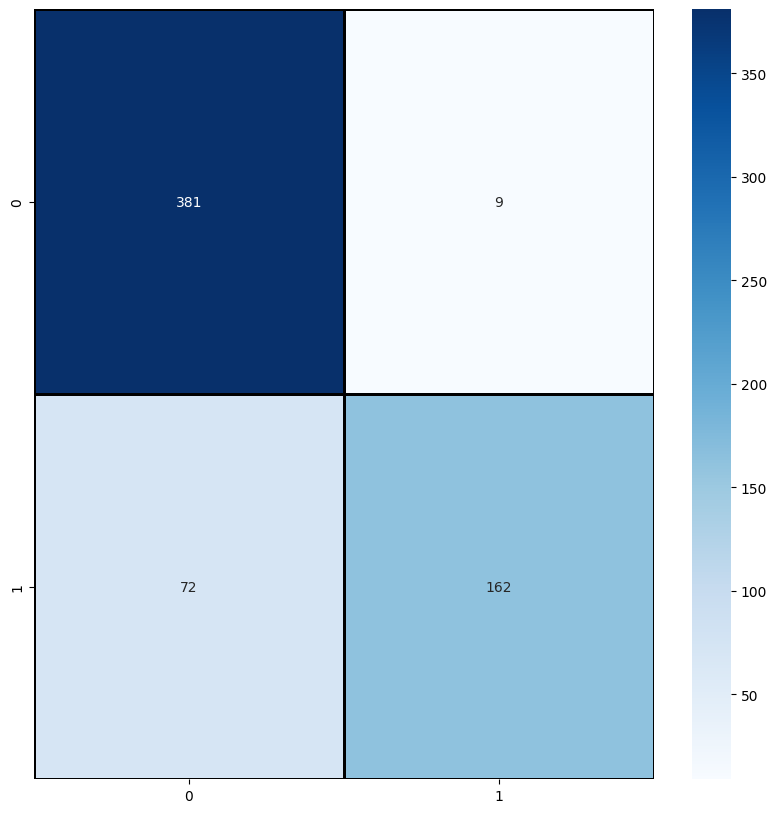

In [150]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [151]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [156]:
model.save('my_model.h5')